<a href="https://colab.research.google.com/github/SaraBabakN/hello-world/blob/master/each%20layer%20%2B%20each%20filter%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_set = torchvision.datasets.CIFAR10('./dataset', train=True, download=True,
                                         transform=transforms.Compose([transforms.ToTensor()]))


def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

0it [00:00, ?it/s]

170500096it [00:03, 43671174.24it/s]                               


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset


In [0]:
lr = 0.01
batch_size = 200
dataset_size = 50000
epoch_num = 20

In [0]:
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)
    
class BasicBlock(nn.Module): 
    expansion = 1 
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out    

class myModel(nn.Module):

    def __init__(self, block,groups=1, width_per_group=64):
        super(myModel, self).__init__()
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3,64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64)
        self.layer2 = self._make_layer(block, 64)
        self.layer3 = self._make_layer(block, 128, stride=2)
        self.layer4 = self._make_layer(block, 128,)
        self.layer5 = self._make_layer(block, 256, stride=2)
        self.layer6 = self._make_layer(block, 256)
        self.layer7 = self._make_layer(block, 512, stride=2)
        self.layer8 = self._make_layer(block, 512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , 10)

    def _make_layer(self, block, planes, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes
        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [0]:
def myResnet(pretrained=False, progress=True, **kwargs):
    return myModel(BasicBlock,**kwargs)

In [0]:
myNet = myResnet().cuda()

In [0]:
data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
optimizer = optim.Adam(myNet.parameters(), lr=lr)

In [9]:
for epoch in range(epoch_num):
    correct = 0 
    for batch in data_loader:
        images, labels = batch
        images = images.cuda() 
        labels = labels.cuda()
        preds = myNet(images)
          
        loss = nn.functional.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct = correct + get_num_correct(preds,labels)
    print("epoch", epoch, "accuracy" , correct)

epoch 0 accuracy 18021
epoch 1 accuracy 25611
epoch 2 accuracy 30696
epoch 3 accuracy 33808
epoch 4 accuracy 35977
epoch 5 accuracy 37845
epoch 6 accuracy 39280
epoch 7 accuracy 40697
epoch 8 accuracy 41866
epoch 9 accuracy 43019
epoch 10 accuracy 44069
epoch 11 accuracy 44978
epoch 12 accuracy 45778
epoch 13 accuracy 46398
epoch 14 accuracy 47069
epoch 15 accuracy 47401
epoch 16 accuracy 47905
epoch 17 accuracy 48058
epoch 18 accuracy 48056
epoch 19 accuracy 48328


In [0]:
torch.save(myNet, '/content/drive/My Drive/data1/myNet.pth')

In [0]:
x = myNet.conv1(images)
x = myNet.bn1(x)
x = myNet.relu(x)
x = myNet.maxpool(x)
x = myNet.layer1(x)
x = myNet.layer2(x)
modulList = list(myNet.layer3.modules())
y = modulList[7](x)
z = modulList[2](x)
z = modulList[3](z)
z = modulList[4](z)
z = modulList[5](z)
z = modulList[6](z)
l3 = myNet.layer3(x)


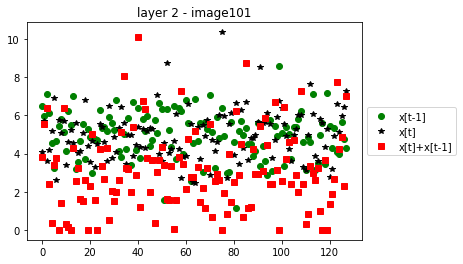

In [44]:
# Singel image, different filters 
imageNumber = 100 
# Whole layer 
a = torch.norm(y[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l3[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (128)
plt.plot(t,a[t] , 'go' , label = "x[t-1]" )
plt.plot(t,b[t] , 'k*' , label = "x[t]")
plt.plot(t,c[t] ,  'rs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 2 - image" + str(imageNumber + 1)
plt.title(name)
plt.savefig('/content/drive/My Drive/data1/' + name )

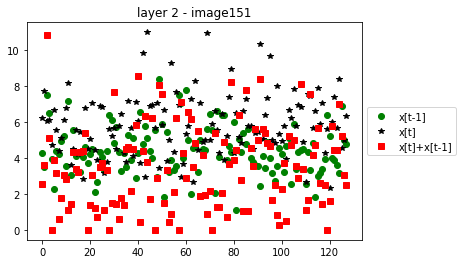

In [45]:
# Singel image, different filters 
imageNumber = 150 
# Whole layer 
a = torch.norm(y[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l3[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (128)
plt.plot(t,a[t] , 'go' , label = "x[t-1]" )
plt.plot(t,b[t] , 'k*' , label = "x[t]")
plt.plot(t,c[t] ,  'rs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 2 - image" + str(imageNumber + 1)
plt.title(name)
plt.savefig('/content/drive/My Drive/data1/' + name )

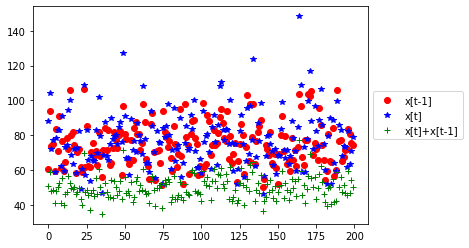

In [20]:
# Whole layer 
a = torch.norm(y.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(z.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
c = torch.norm((l3).reshape(batch_size,-1).clone().detach().cpu(),dim=1)
t= range (batch_size)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] ,  "g+" , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/content/drive/My Drive/data1/layer3')

In [0]:
l4 = myNet.layer4(l3)
modulList = list(myNet.layer5.modules())
y5 = modulList[7](l4)
z5 = modulList[2](l4)
z5 = modulList[3](z5)
z5 = modulList[4](z5)
z5 = modulList[5](z5)
z5 = modulList[6](z5)
l5 = myNet.layer5(l4)

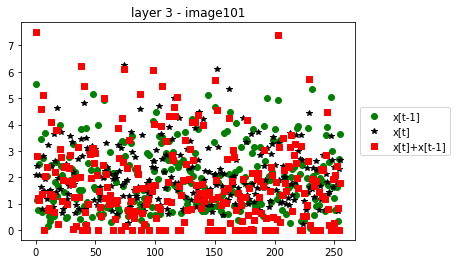

In [43]:
# Singel image, different filters 
imageNumber = 100 
# Whole layer 
a = torch.norm(y5[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z5[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l5[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (256)
plt.plot(t,a[t] , 'go' , label = "x[t-1]" )
plt.plot(t,b[t] , 'k*' , label = "x[t]")
plt.plot(t,c[t] ,  'rs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 3 - image" + str(imageNumber + 1)
plt.title(name)
plt.savefig('/content/drive/My Drive/data1/' + name )

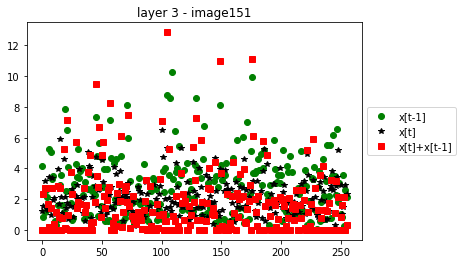

In [46]:
# Singel image, different filters 
imageNumber = 150 
# Whole layer 
a = torch.norm(y5[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z5[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l5[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (256)
plt.plot(t,a[t] , 'go' , label = "x[t-1]" )
plt.plot(t,b[t] , 'k*' , label = "x[t]")
plt.plot(t,c[t] ,  'rs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 3 - image" + str(imageNumber + 1)
plt.title(name)
plt.savefig('/content/drive/My Drive/data1/' + name )

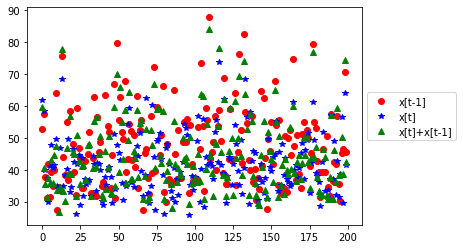

In [23]:
a = torch.norm(y5.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(z5.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
c = torch.norm(l5.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
t= range (batch_size)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] ,  "g^" , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/content/drive/My Drive/data1/layer5')

In [0]:
l6= myNet.layer6(l5)
modulList = list(myNet.layer7.modules())
y7 = modulList[7](l6)
z7 = modulList[2](l6)
z7 = modulList[3](z7)
z7 = modulList[4](z7)
z7 = modulList[5](z7)
z7 = modulList[6](z7)
l7 = myNet.layer7(l6) 

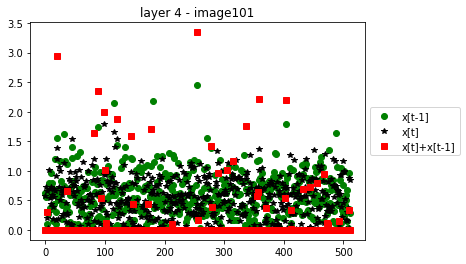

In [42]:
# Singel image, different filters 
imageNumber = 100 
# Whole layer 
a = torch.norm(y7[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z7[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l7[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (512)
plt.plot(t,a[t] , 'go' , label = "x[t-1]" )
plt.plot(t,b[t] , 'k*' , label = "x[t]")
plt.plot(t,c[t] ,  'rs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 4 - image" + str(imageNumber + 1)
plt.title(name)
plt.savefig('/content/drive/My Drive/data1/' + name )

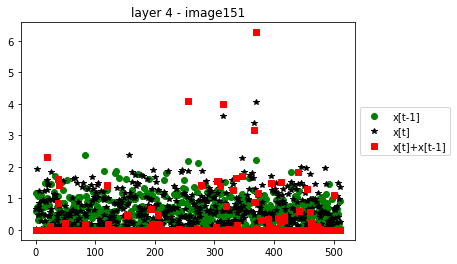

In [47]:
# Singel image, different filters 
imageNumber = 150 
# Whole layer 
a = torch.norm(y7[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(z7[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l7[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (512)
plt.plot(t,a[t] , 'go' , label = "x[t-1]" )
plt.plot(t,b[t] , 'k*' , label = "x[t]")
plt.plot(t,c[t] ,  'rs' , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 4 - image" + str(imageNumber + 1)
plt.title(name)
plt.savefig('/content/drive/My Drive/data1/' + name )

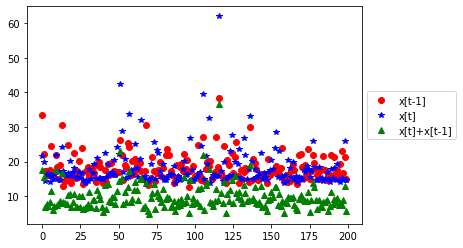

In [25]:
a = torch.norm(y7.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(z7.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
c = torch.norm(l7.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
t= range (batch_size)
plt.plot(t,a[t] , 'ro' , label = "x[t-1]" )
plt.plot(t,b[t] , 'b*' , label = "x[t]")
plt.plot(t,c[t] ,  "g^" , label = "x[t]+x[t-1]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/content/drive/My Drive/data1/layer7')